In [1]:
import pandas as pd
import miceforest as mf
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
def clean_watersprings(df, X, y):
    
    # drop where date is null
    df = df[~df['Date'].isnull()]
    
    # set date as the index
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    df = df.set_index('Date', drop=True)
    df.index.name = None
    df.index.freq = 'D'
    
    # find the latest date of first non-null
    # amongst our targets; throw away all data
    # prior to this point in time
    sent = None
    for c in y:
        data = df[~df[c].isnull()]
        if data.shape[0] > 0:
            d = data.iloc[0].name
            if sent is None or d > sent:
                sent = d
    if sent is not None:
        df = df.loc[sent:]
        
    # 0 in the target always represents a missing value
    for c in y:
        df[c] = df[c].replace(0, float('nan'))
    
    # take the absolute value of some columns
    abs_starts = [
        'Rainfall',
        'Depth_to_Groundwater',
        'Flow_Rate'
    ]
    for beg in abs_starts:
        cols = [c for c in df.columns if c.startswith(beg)]
        for c in cols:
            df[c] = df[c].abs()

    # multiple imputation
    kernel = mf.MultipleImputedKernel(
        data=df,
        save_all_iterations=False,
        random_state=143
    )
    kernel.mice(3, verbose=False)
    df = kernel.impute_new_data(df).complete_data(0)
    
    return df

In [3]:
class WaterspringDataset:
    
    def __init__(self, path, X, y):
        print(f"loading {path}")
        
        self.ycard = len(y)
        self.df = pd.read_csv(path)
        self.df = clean_watersprings(self.df, X, y)
        self.X = self.df.columns[:-self.ycard]
        self.y = self.df.columns[-self.ycard:]
        
        # center & scale the data (*fuller explanation below)
        self.scaler = StandardScaler()
        self.df = pd.DataFrame(
            self.scaler.fit_transform(self.df),
            columns=self.df.columns,
            index=self.df.index
        )
        self.mu = self.scaler.mean_
        self.sigma = self.scaler.scale_
    
    def unscale(self, v):
        if len(v.shape) == 1:
            if self.ycard != 1:
                raise ValueError()
            else:
                return v * self.sigma[0] + self.mu[0]
        elif v.shape[1] != self.ycard:
            raise ValueError()
        else:
            for i, c in enumerate(v.columns):
                v[c] = v[c] * self.sigma[i] + self.mu[i]
            return v

In [4]:
amiata = WaterspringDataset(
    '../data/raw/waterspring/amiata.csv', [
        'Rainfall_Castel_del_Piano', 'Rainfall_Abbadia_S_Salvatore', 'Rainfall_S_Fiora',
        'Rainfall_Laghetto_Verde', 'Rainfall_Vetta_Amiata', 'Depth_to_Groundwater_S_Fiora_8',
        'Depth_to_Groundwater_S_Fiora_11bis', 'Depth_to_Groundwater_David_Lazzaretti',
        'Temperature_Abbadia_S_Salvatore', 'Temperature_S_Fiora', 'Temperature_Laghetto_Verde'
    ], [
        'Flow_Rate_Bugnano', 'Flow_Rate_Arbure',
        'Flow_Rate_Ermicciolo', 'Flow_Rate_Galleria_Alta'
    ])

lupa = WaterspringDataset(
    '../data/raw/waterspring/lupa.csv',
    ['Rainfall_Terni'],
    ['Flow_Rate_Lupa']
)

madonna = WaterspringDataset(
    '../data/raw/waterspring/madonna_di_canneto.csv',
    ['Rainfall_Settefrati', 'Temperature_Settefrati'],
    ['Flow_Rate_Madonna_di_Canneto']
)

loading ../data/raw/waterspring/amiata.csv
loading ../data/raw/waterspring/lupa.csv
loading ../data/raw/waterspring/madonna_di_canneto.csv


In [5]:
class AlwaysZeroPredictor:
    def fit(self, X, y):
        self._outshape = 1 if len(y.shape) == 1 else y.shape[1]
        self._onedim = self._outshape == 1
        return self
    def predict(self, n):
        return np.zeros((n, self._outshape))

In [6]:
class TimeSeriesValidation:
    
    def __init__(self, d):
        self.log = []
        self.d = d
    
    def split(self, X, y):
        self.k = math.floor(X.shape[0] / self.d - 1)
        self.tscv = TimeSeriesSplit(self.k)
        self.X = X
        self.y = y
        return self
    
    def validate(self, m):
        for tr, tt in self.tscv.split(self.X, self.y):
            X_train, X_test = self.X.iloc[tr], self.X.iloc[tt]
            y_train, y_test = self.y.iloc[tr], self.y.iloc[tt]
            m.fit(X_train, y_train)
            y_pred = pd.DataFrame(
                m.predict(y_test.shape[0]),
                columns = y_test.columns,
                index = y_test.index
            )
            rmse = mean_squared_error(y_test, y_pred, squared=False, multioutput='raw_values')
            mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
            self.log.append({
                'train': tr,
                'test': tt,
                'model': m,
                'predictions': y_pred,
                'rmse': rmse,
                'mae': mae
            })
        return self
    
    def report(self):
        rmse = [x['rmse'] for x in self.log]
        rmse = {c: np.mean([x[i] for x in rmse]) for i, c in enumerate(self.y.columns)}
        mae = [x['mae'] for x in self.log]
        mae = {c: np.mean([x[i] for x in mae]) for i, c in enumerate(self.y.columns)}
        rmse['mean'] = np.mean(list(rmse.values()))
        mae['mean'] = np.mean(list(mae.values()))
        rmse['metric'] = 'rmse'
        mae['metric'] = 'mae'
        return rmse, mae
    
    def plot(self, body):
        rmses, maes = self.report()
        fig, axs = plt.subplots(
            len(self.y.columns),
            1,
            figsize=(20, 5 * len(self.y.columns))
        )
        if len(self.y.columns) == 1:
            axs = [axs]
        fig.suptitle(f"{body} Waterspring Predictions | RMSE {rmses['mean']} ... MAE {maes['mean']}", fontweight='bold')
        preds = [x['predictions'] for x in self.log]
        for i, c in enumerate(self.y.columns):
            axs[i].scatter(self.y.index, self.y[c], s=1, alpha=0.75)
            axs[i].set_title(f"{c} | RMSE {rmses[c]} ... MAE {maes[c]}")
            for p in preds:
                axs[i].scatter(p.index, p[c].values, s=1, c='C3', alpha=0.25)
        plt.show()

In [7]:
class HeterogeneousValidation:
    
    def __init__(self, d, m_, names, *ads):
        
        self.names = names
        self.tsvs = []
        for ad in ads:
            tsv = TimeSeriesValidation(d)
            tsv.split(ad.df[ad.X], ad.df[ad.y])
            tsv.validate(m_())
            self.tsvs.append(tsv)
    
    def verbose(self):
        for i, body in enumerate(self.names):
            self.tsvs[i].plot(body)
    
    def concise(self):
        rmses = [tsv.report()[0]['mean'] for tsv in self.tsvs]
        maes = [tsv.report()[1]['mean'] for tsv in self.tsvs]
        return np.mean(rmses), np.mean(maes)

In [8]:
hv = HeterogeneousValidation(
    7,
    AlwaysZeroPredictor,
    ('Amiata', 'Lupa', 'Madonna di Canneto'),
    amiata, lupa, madonna
)

In [9]:
hv.concise()

(0.8166486916867194, 0.8007719493762115)

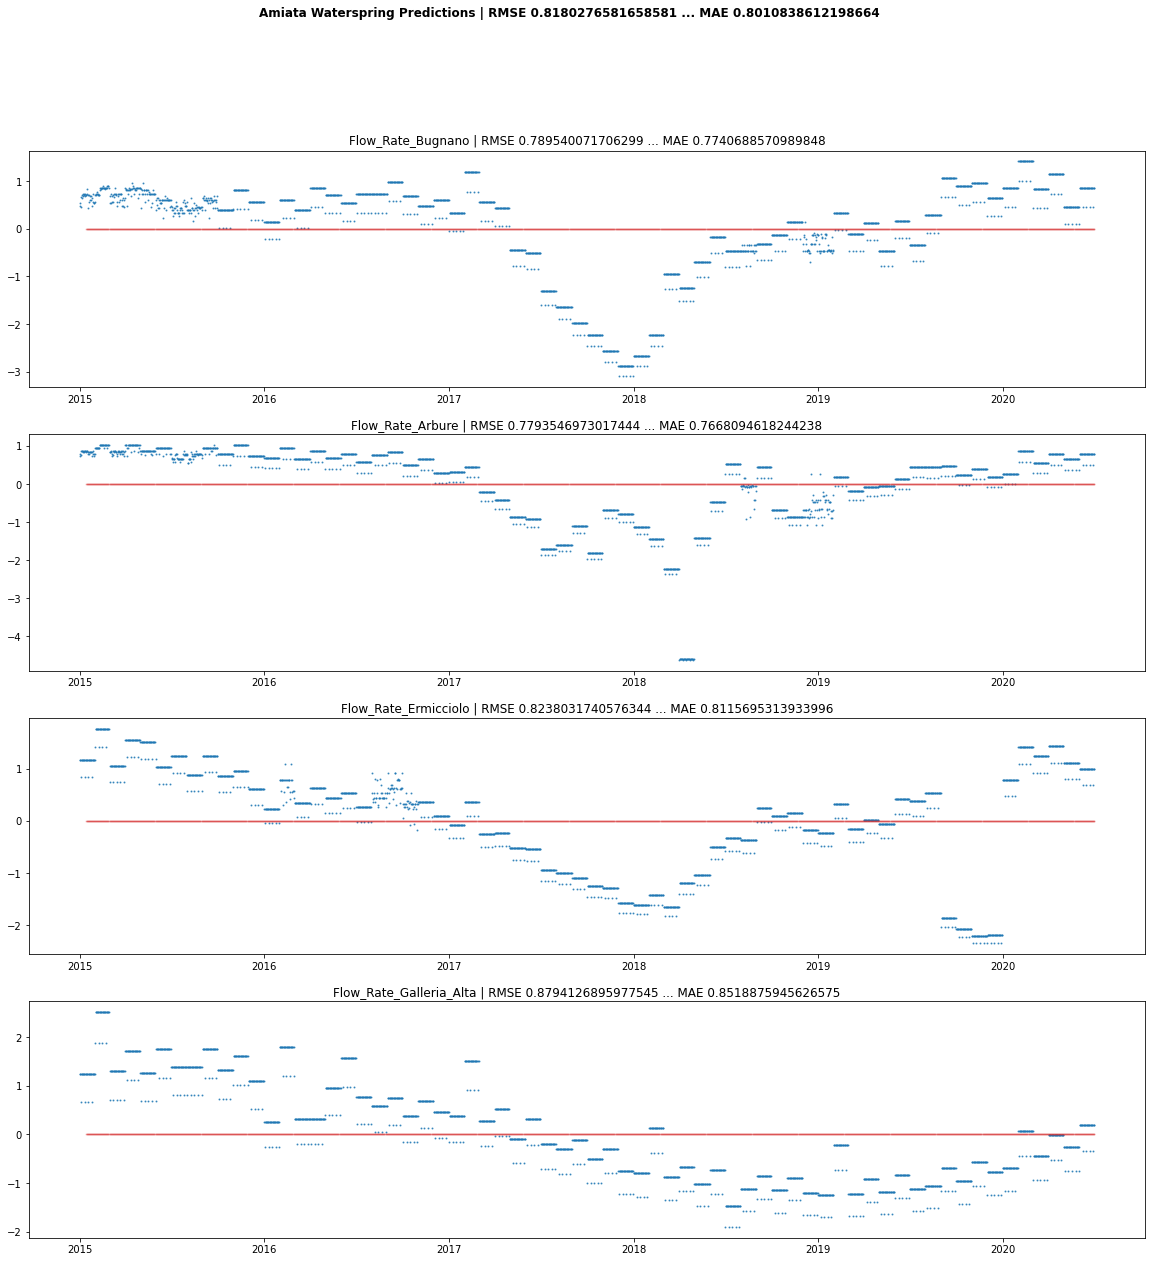

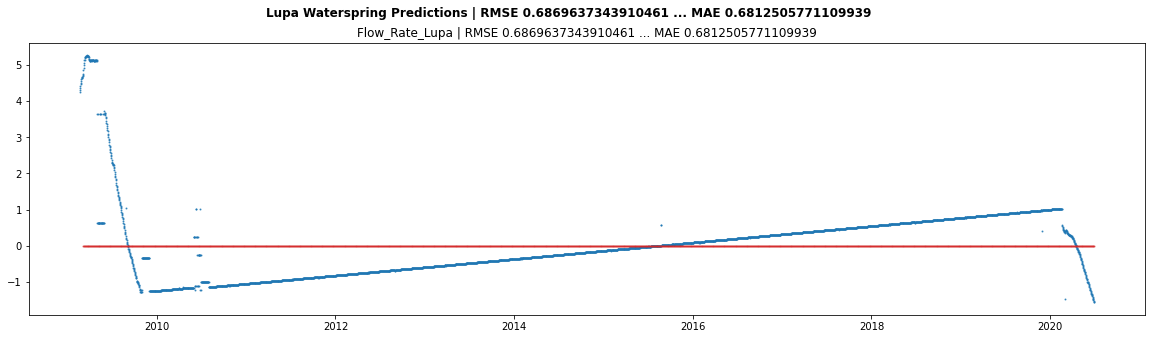

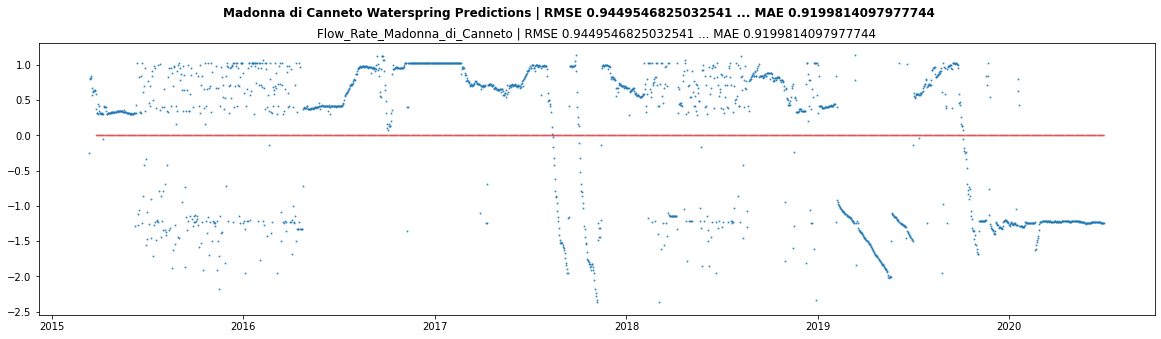

In [10]:
hv.verbose()